In [1]:
import cooler
import numpy as np
import tensorflow as tf
from iced import normalization
import spektral

import matplotlib.pyplot as plt
from IPython import display
import time
tf.keras.backend.set_floatx('float64')

(2432, 2432)
(573, 573)


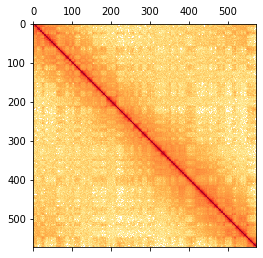

In [2]:
# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.100kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat= c.matrix(balance=True).fetch('chr2')
print(mat.shape)
idxy = ~np.all(np.isnan(mat),axis=0)
M = mat[idxy,:]
Mh = M[:,idxy]
#np.fill_diagonal(Mh, 0)

IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/4),int(Mh.shape[1]/4)
img_l = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH))
for i in list(range(0, len(Mh))):
    x = int(np.floor(i/(len(Mh)/IMG_HEIGHT)))
    for j in list(range(0,len(Mh))):
        y = int(np.floor(j/(len(Mh)/IMG_WIDTH)))
        img_l[x, y] = img_l[x, y] + Mh[i,j]

Ml = img_l
#np.fill_diagonal(Ml, 0)
plt.matshow(np.log2(Ml), cmap='YlOrRd')
print(Ml.shape)

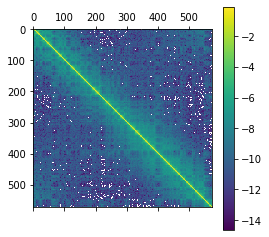

In [3]:
import copy
Ml = img_l
#print('original Ml: ', Ml)
#Ml = normalization.ICE_normalization(Ml)
Ml = normalization.SCN_normalization(Ml)
#print(Ml.sum(0))
plt.matshow(np.log2(Ml))
plt.colorbar()

In [4]:
hic_lr = []
IMG_HEIGHT, IMG_WIDTH = int(512/4),int(512/4)
print(IMG_HEIGHT, IMG_WIDTH)
for i in range(len(Ml)-IMG_HEIGHT+1):
    hic_lr.append(Ml[i:i+IMG_HEIGHT, i:i+IMG_WIDTH])
hic_lr = np.array(hic_lr)
hic_lr = hic_lr[0:2,:,:]
hic_lr_ds = tf.convert_to_tensor(hic_lr)
fig = plt.figure(figsize=(6, 6))
'''for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.log2(hic_lr[i*25,:,:]), cmap='YlOrRd')
    plt.axis('off')'''

128 128


"for i in range(16):\n    plt.subplot(4, 4, i+1)\n    plt.imshow(np.log2(hic_lr[i*25,:,:]), cmap='YlOrRd')\n    plt.axis('off')"

<Figure size 432x432 with 0 Axes>

In [5]:
class GraphConvLayer(tf.keras.layers.Layer):
    def __init__(self, units, name='GCL'):
        super(GraphConvLayer, self).__init__(name=name)
        self.num_outputs = units

    def build(self, input_shape, ):
        init_w = tf.random_normal_initializer(mean=0, stddev=0.1)
        self.w = tf.Variable(initial_value=init_w(shape=(input_shape[1][2], self.num_outputs), dtype=tf.float64), trainable=True)
    
    # ReLU(AXW)
    def call(self, input):
        A = input[0]
        X = input[1]
        A = tf.expand_dims(A, -1)
        A = tf.expand_dims(A, -1)
        X = tf.expand_dims(X, -4)
        AX = tf.multiply(A, X)
        AX = tf.reduce_sum(AX, axis=2)
        #AX = tf.transpose(AX, perm=[1,0,2,3])
        AXW = tf.tensordot(AX, self.w, axes = [[2], [0]])
        AXW = tf.transpose(AXW, perm=[0,1,3,2])

        return AXW


In [6]:
'''def make_discriminator_model():
    InA = tf.keras.layers.Input(shape=(128, 128), name='InA', dtype=tf.float64)
    InX = tf.keras.layers.Input(shape=(128, 255, 1), name='InX', dtype=tf.float64)
    Trans0 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans0')(InX)
    GCL1 = GraphConvLayer(32, name='GCL1')([InA, Trans0])
    Relu1 = tf.keras.layers.ReLU(name='relu1')(GCL1)
    Trans1 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans1')(Relu1)
    GCL2 = GraphConvLayer(1, name='GCL2')([InA, Trans1])
    Relu2 = tf.keras.layers.ReLU(name='relu2')(GCL2)
    Trans2 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans2')(Relu2)
    Flat = tf.keras.layers.Flatten()(Trans2)
    Normal_channel = tf.keras.layers.LayerNormalization(axis=-1 , center=True , scale=True, name='NormalC')(Flat)
    BinaryProbability = tf.keras.layers.Dense(2, activation='relu', use_bias=False)(Normal_channel)
    Out = tf.keras.layers.LayerNormalization(axis=-1 , center=True , scale=True, name='NormalOut')(BinaryProbability)
    model = tf.keras.models.Model(inputs=[InA, InX], outputs=[Out])
    return model'''
    

"def make_discriminator_model():\n    InA = tf.keras.layers.Input(shape=(128, 128), name='InA', dtype=tf.float64)\n    InX = tf.keras.layers.Input(shape=(128, 255, 1), name='InX', dtype=tf.float64)\n    Trans0 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans0')(InX)\n    GCL1 = GraphConvLayer(32, name='GCL1')([InA, Trans0])\n    Relu1 = tf.keras.layers.ReLU(name='relu1')(GCL1)\n    Trans1 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans1')(Relu1)\n    GCL2 = GraphConvLayer(1, name='GCL2')([InA, Trans1])\n    Relu2 = tf.keras.layers.ReLU(name='relu2')(GCL2)\n    Trans2 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_cons

In [7]:
def make_discriminator_model():
    InA = tf.keras.layers.Input(shape=(128, 128), name='InA', dtype=tf.float64)
    InX = tf.keras.layers.Input(shape=(128, 255), name='InX', dtype=tf.float64)
    graph_conv_1 = spektral.layers.GraphConv(32, activation='relu')([InX, InA])
    '''[pl_X_1, pl_A_1] = spektral.layers.MinCutPool(64)([graph_conv_1, InA])

    graph_conv_2 = spektral.layers.GraphConv(8, activation='relu')([pl_X_1, pl_A_1])
    [pl_X_2, pl_A_2] = spektral.layers.MinCutPool(32)([graph_conv_2, pl_A_1])

    graph_conv_3 = spektral.layers.GraphConv(4, activation='relu')([pl_X_2, pl_A_2])
    [pl_X_3, pl_A_3] = spektral.layers.MinCutPool(16)([graph_conv_3, pl_A_2])

    graph_conv_4 = spektral.layers.GraphConv(2, activation='relu')([pl_X_3, pl_A_3])
    [pl_X_4, pl_A_4] = spektral.layers.MinCutPool(8)([graph_conv_4, pl_A_3])

    flt = tf.keras.layers.Flatten()(pl_X_4)
    Out = tf.keras.layers.Dense(1)(flt)'''

    model = tf.keras.models.Model([InA, InX], [graph_conv_1]) # pl_A_1, graph_conv_2, pl_A_2, graph_conv_3, pl_A_3, graph_conv_4
    return model

In [8]:
class Rank1Reconstruct(tf.keras.layers.Layer):
    def __init__(self, filters, name='RR'):
        super(Rank1Reconstruct, self).__init__(name=name)
        self.num_outputs = filters
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,1,filters), dtype='float64'))
        
    def build(self, input_shape):
        pass
        
    def call(self, input):
        v = tf.math.add(input, tf.constant(1e-6, dtype=tf.float64))
        vt = tf.transpose(v, perm=[0,2,1,3])
        rank1m = tf.multiply(tf.multiply(v, vt), self.w)
        return rank1m

class Normal(tf.keras.layers.Layer):
    def __init__(self, input_dim, name='DW'):
        super(Normal, self).__init__(name=name)
        #w_init = tf.ones_initializer()
        #self.w = tf.Variable(initial_value=w_init(shape=(1, input_dim, 1, 1), dtype='float64'), trainable=True)
        d_init = tf.zeros_initializer()
        self.d = tf.Variable(initial_value=d_init(shape=(1, input_dim), dtype='float64'), trainable=True)

    def call(self, inputs):
        rowsr = tf.math.sqrt(tf.math.reduce_sum(tf.multiply(inputs, inputs), axis=1, keepdims=True))
        colsr = tf.math.sqrt(tf.math.reduce_sum(tf.multiply(inputs, inputs), axis=2, keepdims=True))
        sumele = tf.math.multiply(rowsr, colsr)
        #tf.math.divide_no_nan(inputs, sumele)
        Div = tf.math.divide_no_nan(inputs, sumele)
        #self.w.assign(tf.nn.relu(self.w))
        self.d.assign(tf.nn.relu(self.d))
        #WT = tf.transpose(self.w, perm=[0,2,1,3])
        #M = tf.multiply(self.w, WT)
        opd = tf.linalg.LinearOperatorToeplitz(self.d, self.d)
        opd = tf.expand_dims(opd.to_dense(), axis=-1)
        out = tf.add(Div, opd)#tf.add(tf.multiply(Div, M), opd)
        #out = tf.multiply(Div, M)
        return out

In [9]:
def make_generator_model():
    In = tf.keras.layers.Input(shape=(128, 128, 1), name='In', dtype=tf.float64)

    Dec1 = tf.keras.layers.Conv2D(64, [1, 128], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec1')(In) 

    #Drop1 = tf.keras.layers.Dropout(0.5)(Dec1)
    Rec1 = Rank1Reconstruct(64, name='Rec1')(Dec1)
    Sum1 = tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=10.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum1')(Rec1)

    out = Normal(128, name='Out')(Sum1)

    model = tf.keras.models.Model(inputs=[In],outputs=[out])
    return model

W0411 10:57:41.013402 4656549312 deprecation.py:506] From /Users/huyangyang/anaconda3/envs/TF_base/lib/python3.7/site-packages/tensorflow_core/python/ops/linalg/linear_operator_toeplitz.py:158: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
In (InputLayer)              [(None, 128, 128, 1)]     0         
_________________________________________________________________
Dec1 (Conv2D)                (None, 128, 1, 64)        8192      
_________________________________________________________________
Rec1 (Rank1Reconstruct)      (None, 128, 128, 64)      64        
_________________________________________________________________
Sum1 (Conv2D)     

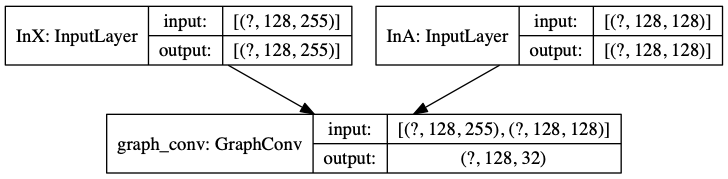

In [10]:
Gen = make_generator_model()
Dis = make_discriminator_model()
print(Gen.summary())
tf.keras.utils.plot_model(Gen, to_file='G.png',show_shapes=True)
print(Dis.summary())
tf.keras.utils.plot_model(Dis, to_file='D.png', show_shapes=True)

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss_label(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_loss_recon(features, adj):
    M = tf.matmul(features, tf.transpose(features, perm=[0,2,1]))
    M = tf.nn.sigmoid(M)
    return tf.keras.losses.MSE(adj, M)

def generator_loss(y_pred, y_true):
    #return cross_entropy(tf.ones_like(fake_output), fake_output)
    #return tf.reduce_mean(tf.abs(y_pred - y_true))
    return 1 - tf.image.ssim(y_pred, y_true, max_val=1.0)
    '''return tf.add(
        tf.math.reduce_std(
            tf.math.divide_no_nan(tf.subtract(y_true, y_pred), y_true), 
            axis=[1,2,3]), 
        tf.math.reduce_mean(
            tf.math.divide_no_nan(tf.abs(tf.subtract(y_true, y_pred)), y_true), 
            axis=[1,2,3])
        )'''

In [12]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adagrad()
discriminator_optimizer_adj = tf.keras.optimizers.Adam()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=Gen,
                                 discriminator=Dis)

In [13]:
@tf.function
def train_step(A, X, img, mFilter):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape(persistent=True) as disc_adj_tape:
        fake_hic = Gen(img, training=True)

        #real_output = Dis([A, tf.squeeze(X, axis=-1)], training=True)
        #A_f = tf.squeeze(tf.cast(fake_hic>1e-2, dtype=tf.float64), axis=-1)

        #mFilter = tf.expand_dims(mFilter, axis=0)
        #X_f = tf.multiply(fake_hic, mFilter)
        #X_f = tf.math.reduce_sum(X_f, axis= 2)
        #X_f = tf.expand_dims(X_f, axis=-1)
        #fake_output = Dis([A_f, tf.squeeze(X_f, axis=-1)], training=True)

        gen_loss = generator_loss(fake_hic, img)
        #disc_loss = discriminator_loss_label(real_output[0], fake_output[0])
        #disc_adj_loss_1_T = discriminator_loss_recon(real_output, A)
        #disc_adj_loss_1_F = discriminator_loss_recon(fake_output[1], A_f)

        gradients_of_generator = gen_tape.gradient(gen_loss, Gen.trainable_variables)
        #gradients_of_discriminator = disc_tape.gradient(disc_loss, Dis.trainable_variables)
        #radients_of_discriminator_1_T = disc_adj_tape.gradient(disc_adj_loss_1_T, Dis.trainable_variables)
        #gradients_of_discriminator_1_F = disc_adj_tape.gradient(disc_adj_loss_1_F, Dis.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, Gen.trainable_variables))
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, Dis.trainable_variables))
        #discriminator_optimizer_adj.apply_gradients(zip(gradients_of_discriminator_1_T, Dis.trainable_variables))
        #discriminator_optimizer_adj.apply_gradients(zip(gradients_of_discriminator_1_F, Dis.trainable_variables))



In [23]:
def train(dataset, A, X, epochs, BATCH_SIZE, mFilter):
    #print(dataset)
    for epoch in range(epochs):
        start = time.time()
        for i, image_batch in enumerate(dataset):
            A_batch = tf.convert_to_tensor(A[i:i+BATCH_SIZE,:,:], dtype=tf.float64)
            X_batch = tf.convert_to_tensor(X[i:i+BATCH_SIZE,:,:], dtype=tf.float64)
            train_step(A_batch, X_batch, image_batch, mFilter)

        # Save the model every 25 epochs
        if (epoch + 1) % 25 == 0:
            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(Gen, epoch + 1, None)
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec.'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #generate_and_save_images(Gen, epochs, None)

In [24]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    test_input = np.ones(shape=[1,128,128,1])
    test_input[0,:,:,0] = hic_lr[0,:,:]
    predictions = tf.squeeze(model(test_input, training=False))
    #print('Pred: ', predictions)
    rows = 3
    cols = 3
    plt.figure(figsize=(6, 6), constrained_layout=True)
    plt.subplot(rows,cols,1)
    plt.imshow(np.log2(np.squeeze(hic_lr[0,:,:])))
    #plt.axis('off')
    plt.title('Original')
    plt.subplot(rows,cols,2)
    plt.imshow(np.log2(predictions))
    #plt.axis('off')
    plt.title('X Hat')
    plt.subplot(rows,cols,3)
    plt.imshow(np.log2(np.squeeze(hic_lr[0,:,:])-predictions), cmap='RdBu')
    #plt.axis('off')
    plt.title('Diff')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Sum1').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,4)
    plt.imshow(np.log2(np.squeeze(intermediate_output)), cmap='RdBu')
    #plt.axis('off')
    plt.title('before WX+b')
    m = model.get_layer('Out').get_weights()
    plt.subplot(rows,cols,5)
    #plt.plot(np.squeeze(m[0]))
    plt.title('W')
    plt.subplot(rows,cols,6)
    plt.plot(np.squeeze(m[0]))
    plt.title('bias')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Dec1').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,7)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')

    plt.savefig('./lvl1/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [25]:
EPOCHS = 800
BUFFER_SIZE = 1
BATCH_SIZE = 1
train_dataset = tf.data.Dataset.from_tensor_slices(hic_lr[..., np.newaxis]).batch(BATCH_SIZE)
A_lr = (hic_lr>1e-1).astype(dtype=float)
A_dataset = tf.data.Dataset.from_tensor_slices(A_lr).batch(BATCH_SIZE)
X_lr = np.zeros(shape=(A_lr.shape[0], A_lr.shape[1], 2*A_lr.shape[2]-1), dtype=float)
n = X_lr.shape[1]

for i in list(range(0, X_lr.shape[1])):
    X_lr[:,i,n-1-i:(n-1-i)+n] = A_lr[:, i, :]
X_dataset = tf.data.Dataset.from_tensor_slices(X_lr).batch(BATCH_SIZE)

mFilter = np.zeros(shape=(A_lr.shape[1], A_lr.shape[1], 2*A_lr.shape[2]-1))
for i in list(range(0, mFilter.shape[2])):
    mlen = i+1 if i<128 else 255-i
    mFilter[:,:,i] = np.diag(np.ones(shape=(mlen,)), k=i-(A_lr.shape[1]-1))
mFilter = tf.convert_to_tensor(mFilter, dtype=tf.float64)



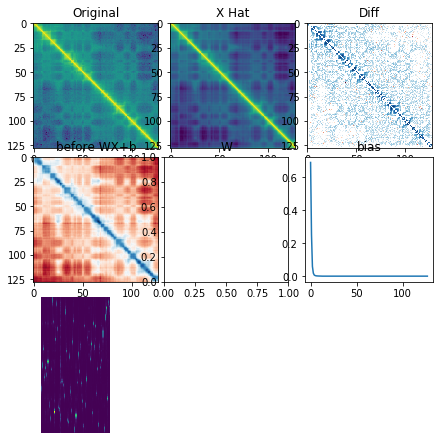

Time for epoch 800 is 8.05554986000061 sec.


In [26]:
train(train_dataset, A_lr, X_lr[..., np.newaxis], EPOCHS, BATCH_SIZE, mFilter)

[[-0.02797394  0.08124819  0.07613232 ... -2.77087097 -1.7574666
  -8.10529764]
 [ 0.08122426 -0.03007227 -0.00947951 ... -2.25414993 -1.10552461
  -1.23655109]
 [ 0.07608503 -0.00950489 -0.01804132 ... -1.11469641 -0.98874447
  -3.57921228]
 ...
 [-2.79823158 -2.27767596 -1.12993117 ... -0.14392471 -0.1343501
   0.11336895]
 [-1.77782178 -1.12101201 -1.00332253 ... -0.13449207 -0.06620806
   0.12513195]
 [-8.17290111 -1.25309797 -3.61297513 ...  0.11322032  0.12509479
  -0.0944611 ]]
T:  356.06681302400364
pred:  363.83160109067705
diff:  50.646322766725206


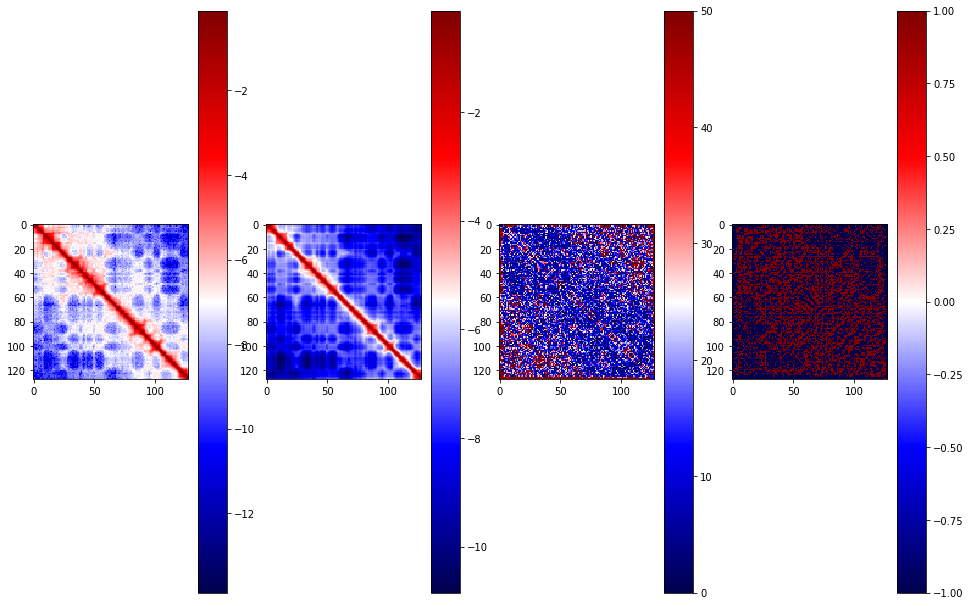

In [29]:
import iced
import copy
test_input = np.ones(shape=[1,128,128,1])
test_input[0,:,:,0] = copy.copy(hic_lr[1,:,:])
predictions = tf.squeeze(Gen(test_input, training=False))
hic_pred = predictions.numpy()
#hic_pred = normalization.SCN_normalization(hic_pred)
plt.figure(figsize=(16,24))
plt.subplot(1,4,1)
T = np.squeeze(test_input[0,:,:])
pct = np.percentile(T, 100)
T[T>pct] = pct
plt.imshow(np.log2(T), cmap='seismic')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(np.log2(hic_pred), cmap='seismic')
plt.colorbar()
plt.subplot(1,4,3)
diff = (T - hic_pred)
Diffpercent = np.divide(diff, T, out=np.zeros_like(T), where=T!=0)
plt.imshow(np.abs(Diffpercent*100), cmap='seismic')
plt.clim(0,50)
print(Diffpercent)
plt.colorbar()
plt.subplot(1,4,4)
diff[diff>0] = 1
diff[diff<0] = -1
plt.imshow((diff), cmap='seismic')
plt.colorbar()

print('T: ', np.sum(T))
print('pred: ', np.sum(hic_pred))
print('diff: ', np.sum(np.abs(T-hic_pred)))

Text(0.5, 1.0, 'X hat')

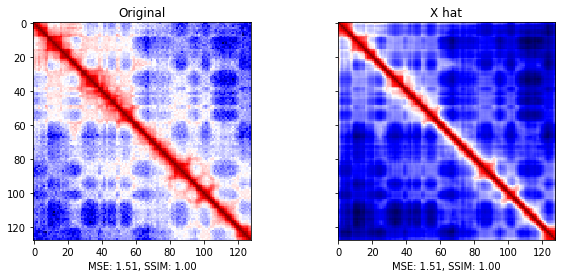

In [30]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse
def mse(x, y):
    return np.linalg.norm(x - y) #The Frobenius norm

T = np.squeeze(test_input[0,:,:])
pct = np.percentile(T, 100)
T[T>pct] = pct

P = copy.copy(hic_pred)
pct = np.percentile(P, 100)
P[P>pct] = pct

mse_noise = mse(T, P)
ssim_noise = ssim(T, P, data_range=T.max() - T.min())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(np.log2(T), cmap='seismic')
ax[0].set_xlabel(label.format(mse_noise, ssim_noise))
ax[0].set_title('Original')

ax[1].imshow(np.log2(P), cmap='seismic')
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('X hat')

In [ ]:
Gen.save('./saved_model/gen_model') 

In [ ]:
intermediate_layer_model = tf.keras.models.Model(inputs=Gen.input, outputs=Gen.get_layer('Rec1').output )
intermediate_output = intermediate_layer_model.predict(test_input)
#print(intermediate_output.shape)
step = 2
fig = plt.figure(figsize=(10, 10), constrained_layout=False)
for i in range(0,64):#,intermediate_output.shape[3],step):
    #print(i)
    plt.subplot(16, 16, i+1)
    plt.imshow(np.log2(np.squeeze(intermediate_output[0, :, :, i])), cmap='YlOrRd')
    plt.axis('off')
fig = plt.figure(figsize=(10, 10), constrained_layout=False)
for i in range(0,64):#,intermediate_output.shape[3],step):
    #print(i)
    plt.subplot(16, 16, i+1)
    plt.imshow((np.squeeze(intermediate_output[0, :, :, i])), cmap='YlOrRd')
    plt.axis('off')
#plt.savefig('./lvl4/image_features_log2.png')
plt.show()

In [ ]:
import imageio
import glob
anim_file = 'gcn_1.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./lvl1/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)